In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import datetime as dt
import numpy as np

In [2]:
years = list(range(2022, 2016, -1))
print(years)
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

[2022, 2021, 2020, 2019, 2018, 2017]


In [3]:
for year in years:  # loop for all years in range
    print(year)
    data = requests.get(standings_url) # request page
    soup = BeautifulSoup(data.text) # extract all information form page
    standings_table = soup.select('table.stats_table')[0] # log the standings table for the current year

    links = [l.get("href") for l in standings_table.find_all('a')] # get the reference to all the links from all links on page
    links = [l for l in links if '/squads/' in l] # all links with '/squads/' in order to find the team pages for all clubs
    team_urls = [f"https://fbref.com{l}" for l in links] # absolute links for club specific pages
    
    previous_season = soup.select("a.prev")[0].get("href") # set new standings page to the previous season for next loop
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls: # loop for all team links on standings page
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ") # parse team name
        print(team_name)
        data = requests.get(team_url)
        
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0] # Scores and fixtures dataframe for the club
        matches = matches[['Date', 'Time', 'Comp', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA', 'Opponent', 'Attendance', 'Captain', 'Formation','Referee']]

        soup = BeautifulSoup(data.text) # extract all information from page
        links = soup.find_all('a') # find all links on page for the club
        links = [l.get("href") for l in links] # get reference urls for those links
        links = [l for l in links if l and (('all_comps/shooting/' in l) or ('all_comps/possession/' in l) or ('all_comps/passing/' in l) or ('all_comps/defense/' in l))] # filter to only shooting stats links
        links = [*set(links)]

        df_info = {
            'matches': {
                'name': 'Matches',
                'column_levels': [],
                'df': matches,
            },
            'shooting': {
                'name': 'Shooting',
                'column_levels': ['Expected', '', 'Standard', ''],
                'df': pd.DataFrame()
            },
            'possession': {
                'name': 'Possession',
                'column_levels': ['Carries', 'Dribbles', '', 'Receiving', 'Touches', ''],
                'df': pd.DataFrame()
            },
            'passing': {
                'name': 'Passing',
                'column_levels': ['', 'Long', 'Medium', 'Short', 'Total', '', '', '', '', '', '', '', ''],
                'df': pd.DataFrame()
            },
            'defense': {
                'name': 'Defensive Actions',
                'column_levels': ['Blocks', '', 'Pressures', 'Tackles', '', '', '', '', '', 'Vs Dribbles'],
                'df': pd.DataFrame()
            }
        }

        # Update dataframes in our dictionary to pull web page tables
        for l in links:
            for key, webster in df_info.items():

                if (key != 'matches') and ('all_comps/'+ key in l):
                        data = requests.get(f"https://fbref.com{l}") # pull that data for the stats link
                        webster['df'] = pd.read_html(data.text, match=webster['name'])[0] # read the link's data from the table
                        d = dict(zip(webster['df'].columns.levels[0], webster['column_levels'])) # Clear out unecessary multi indexed column names and rename columns to specify features
                        webster['df'] = webster['df'].rename(columns=d, level=0)

        # Clean dataframe structure
        for key, webster in df_info.items():
            if (key != 'matches'):
                webster['df'].columns = ['_'.join(col).strip() for col in webster['df'].columns.values]
            webster['df'].columns = webster['df'].columns.str.lstrip("_")
            webster['df'].columns = webster['df'].columns.str.replace(' ', '_')
            webster['df'].columns = webster['df'].columns.str.replace('-', '_')
            webster['df'].columns = webster['df'].columns.str.replace(':', '_')
            webster['df'].columns = webster['df'].columns.str.lower()
            webster['df'] = webster['df'].set_index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent'])
            webster['df'] = webster['df'].add_prefix(key + '_')
            webster['df'] = webster['df'].reset_index()
        
        try:
            team_data = df_info['matches']['df'].copy()
            for key, webseter in df_info.items():
                if (key != 'matches'):
                    team_data = team_data.merge(df_info[key]['df'], on=['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent'])

        except ValueError:
            continue

        team_data = team_data[team_data["comp"] == "Premier League"]
        
        team_data["team"] = team_name
        all_matches.append(team_data)
        time.sleep(1)


match_df = pd.concat(all_matches).reset_index(drop=True)
match_df = match_df.sort_values('date', ascending=False)

2022
Arsenal
Manchester City
Tottenham Hotspur
Brighton and Hove Albion
Leeds United
Fulham
Southampton
Chelsea
Brentford
Newcastle United
Manchester United
Liverpool
Crystal Palace
Nottingham Forest
Everton
Aston Villa
West Ham United
Bournemouth
Wolverhampton Wanderers
Leicester City
2021
Manchester City
Liverpool
Chelsea
Tottenham Hotspur
Arsenal
Manchester United
West Ham United
Leicester City
Brighton and Hove Albion
Wolverhampton Wanderers
Newcastle United
Crystal Palace
Brentford
Aston Villa
Southampton
Everton
Leeds United
Burnley
Watford
Norwich City
2020
Manchester City
Manchester United
Liverpool
Chelsea
Leicester City
West Ham United
Tottenham Hotspur
Arsenal
Leeds United
Everton
Aston Villa
Newcastle United
Wolverhampton Wanderers
Crystal Palace
Southampton
Brighton and Hove Albion
Burnley
Fulham
West Bromwich Albion
Sheffield United
2019
Liverpool
Manchester City
Manchester United
Chelsea
Leicester City
Tottenham Hotspur
Wolverhampton Wanderers
Arsenal
Sheffield United
Bu

In [4]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [234]:
# Cleaning and Data Preprocessing
df = match_df.copy()

df = df.astype({'gf': int, 'ga': int})
df.loc[:,'date'] = df['date'].str.cat(df.loc[:,'time'], sep=' ')
df.loc[:,'date'] = pd.to_datetime(df.loc[:,'date'])
df.loc[:,'hour'] = df.loc[:,'date'].dt.hour
df.loc[:, 'day_weekend'] = df.loc[:,'date'].dt.day.isin([5,6])
df['is_home'] = (df.loc[:,'venue'] == 'Home')
df["is_win"] = (df.loc[:, "result"] == 'W')

columns = pd.read_csv('webster.csv')
columns = list(columns['feature'])
df = df[columns]

df = df.dropna()

df.loc[:,'team_name'] = df.loc[:,'team']
df.loc[:,'opponent_name'] = df.loc[:,'opponent']

df = pd.get_dummies(data=df, columns=['team_name', 'opponent_name', 'matches_referee'])

df = df[df["date"] < '2022-07-01']
df = df.sort_values('date', ascending=False)

In [235]:
# Column Reference Lists
numerics = ['int32', 'float16', 'float32', 'float64']
columns_numeric = list((df.select_dtypes(include=numerics).columns))

columns_match_info = columns_numeric.copy()
columns_match_info.append('is_win')
columns_prev_ecounter = [f"{c}_prev_encounter" for c in columns_match_info]

columns_recent_form = ['is_win']

In [236]:
# Get Statistics from previous Encounter
def rolling_info(group, cols, new_cols, num, func):
    group = group.sort_values("date")
    rolling_stats = func(group[cols].rolling(num, closed='left'))
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [232]:
def rolling_mean(obj):
    return obj.mean()

def rolling_sum(obj):
    return obj.sum()

In [237]:
# Add previous enounter stats
df = df.groupby(['team','opponent']).apply(lambda x: rolling_info(x, columns_match_info, columns_prev_ecounter, 1, rolling_mean))
df.droplevel(['team', 'opponent'])
df = df.reset_index(drop=True)
df['is_win_prev_encounter'] = df['is_win_prev_encounter'].astype(bool)

In [238]:
# Stats average from past 3 matches
columns_rolling_3_mean = [f"{c}_rolling_3_mean" for c in columns_numeric]
df = df.groupby("team").apply(lambda x: rolling_info(x, columns_numeric, columns_rolling_3_mean, 3, rolling_mean))
df = df.droplevel('team')
df = df.reset_index(drop=True)

In [239]:
# Stats average from past 5 matches
columns_rolling_5_mean = [f"{c}_rolling_5_mean" for c in columns_numeric]
df = df.groupby("team").apply(lambda x: rolling_info(x, columns_numeric, columns_rolling_5_mean, 5, rolling_mean))
df = df.droplevel('team')
df = df.reset_index(drop=True)

In [240]:
# number of wins in the past 5 matches
columns_wins_past_5 = [f"{c}_past_5" for c in columns_recent_form]
df = df.groupby("team").apply(lambda x: rolling_info(x, columns_recent_form, columns_wins_past_5, 5, rolling_sum))
df = df.droplevel('team')
df = df.reset_index(drop=True)

In [241]:
# pd.DataFrame(list(df.columns)).to_csv('predictors.csv', index=False)
non_predictors = list(pd.read_csv('predictors.csv')['feature'])

In [67]:
# season_2021_2022 = df.copy()
# season_2021_2022 = season_2021_2022[(season_2021_2022['date'] < '2022-06-06') & (season_2021_2022['date'] >= '2021-06-06')]

In [242]:
from sklearn.model_selection import train_test_split

y = df['is_win']
x = df.drop(columns = non_predictors)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)

In [167]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(logreg, 100)
rfe = rfe.fit(x_train, y_train.values.ravel())

c:\Users\kdmor\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=100 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\Users\kdmor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kdmor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



In [168]:
rfe_results = pd.DataFrame(data={'feature': list(x_train.columns), 'rfe_inclusion': list(rfe.support_)})
rfe_features = list(rfe_results[rfe_results['rfe_inclusion'] == True]['feature'])
rfe_features

['hour',
 'is_home',
 'opponent_name_Liverpool',
 'gf_prev_encounter',
 'ga_prev_encounter',
 'shooting_standard_sh_prev_encounter',
 'shooting_standard_sot_prev_encounter',
 'shooting_standard_sot%_prev_encounter',
 'shooting_expected_xg_prev_encounter',
 'shooting_expected_npxg_prev_encounter',
 'shooting_expected_g_xg_prev_encounter',
 'shooting_expected_np_g_xg_prev_encounter',
 'possession_poss_prev_encounter',
 'possession_touches_touches_prev_encounter',
 'possession_touches_mid_3rd_prev_encounter',
 'possession_dribbles_succ_prev_encounter',
 'possession_dribbles_att_prev_encounter',
 'possession_dribbles_#pl_prev_encounter',
 'possession_dribbles_megs_prev_encounter',
 'possession_carries_cpa_prev_encounter',
 'possession_carries_dis_prev_encounter',
 'possession_receiving_targ_prev_encounter',
 'passing_total_cmp%_prev_encounter',
 'passing_short_att_prev_encounter',
 'passing_medium_cmp_prev_encounter',
 'passing_medium_cmp%_prev_encounter',
 'passing_long_cmp%_prev_encounte

In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# x_train = x_train[rfe_features]
# x_test = x_test[rfe_features]

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

c:\Users\kdmor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [244]:
y_pred = logreg.predict(x_test)

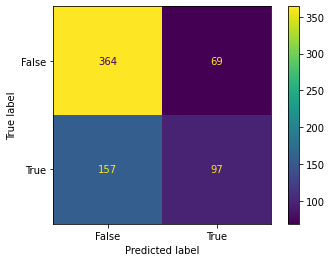

In [245]:
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [246]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('precision: ' + str(precision_score(y_test, y_pred)))
print('recall: ' + str(recall_score(y_test, y_pred)))

accuracy: 0.6710334788937409
precision: 0.5843373493975904
recall: 0.38188976377952755


In [247]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.70      0.84      0.76       433
        True       0.58      0.38      0.46       254

    accuracy                           0.67       687
   macro avg       0.64      0.61      0.61       687
weighted avg       0.66      0.67      0.65       687



In [248]:
y_pred_a = logreg.predict_proba(x_test)


In [249]:
match_info = ['team','opponent','date']
matches = df[match_info]
combined = pd.DataFrame(dict(actual=y_test, predicted=y_pred, prob_win=y_pred_a[:,1]))
matches = matches.merge(combined, left_index=True, right_index=True)

matches = matches[(matches['prob_win'] > 0.65) | (matches['prob_win'] < 0.35)]
matches['accurate'] = (matches['actual'] == matches['predicted'])
matches['accurate'].value_counts()

True     262
False     98
Name: accurate, dtype: int64

In [250]:
matches

,team,opponent,date,actual,predicted,prob_win,accurate
0,Arsenal,Newcastle Utd,2018-04-15 13:30:00,False,True,0.659010,False
27,Arsenal,Manchester City,2019-02-03 16:30:00,False,False,0.325949,True
46,Arsenal,Manchester Utd,2019-09-30 20:00:00,False,False,0.327115,True
71,Arsenal,Leicester City,2020-07-07 20:15:00,False,False,0.269819,True
108,Arsenal,Newcastle Utd,2021-05-02 14:00:00,True,True,0.674296,True
114,Arsenal,Manchester City,2021-08-28 12:30:00,False,False,0.328202,True
146,Arsenal,Leeds United,2022-05-08 14:00:00,True,False,0.320391,False
151,Aston Villa,Manchester Utd,2020-07-09 20:15:00,False,False,0.215280,True
153,Aston Villa,Everton,2020-07-16 18:00:00,False,False,0.257496,True
156,Aston Villa,Sheffield Utd,2020-09-21 18:00:00,True,False,0.335793,False


In [175]:
combined = pd.DataFrame(dict(actual=y_test, predicted=y_pred))
combined

,actual,predicted
2600,True,False
1312,False,False
1530,True,True
1085,False,False
27,False,False
648,True,True
472,False,False
2631,False,False
451,True,False
893,False,False
